In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/gillestellier/miniforge3/envs/jupyenv/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

In [2]:
# Dossier contenant les images
IMAGE_DIR = "./Images/"  

# Chargement des images
def load_images(image_dir):
    images = []
    filenames = []
    for file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            filenames.append(file)
    return images, filenames



In [3]:
# Chargement de la liste des images
from os import listdir

list_photos = [file for file in listdir(IMAGE_DIR)]
print(len(list_photos))

1050


In [4]:
import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder


def select_n_components(features, goal_var: float) -> int:
    """ 
    La méthode PCA de sklearn permet de selectionner un float en n_compoents afin de ne garder que 0.99 (par ex) de la variance totale mais cela n'est pas possible pour la méthode SVD.
    Cette function permet de récupérer le nombre de composantes expliquant X%  de la variance totale par la méthode de réduction SVD. 
    """

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components

##########################################
##########################################

# Calcul Reduction, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def reduction_fct(features, reduc='SVD'):
    """ Cette fonction permet de réduire et clusteriser des données 
    avec le choix de l'algorithme de réduction dans les arguments : SVD, UMAP ou TSNE
    """

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")

##########################################
##########################################


def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


##########################################
##########################################

def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

In [5]:
# Import du DF déjà clean

data = pd.read_csv("data_cleaned.csv")

In [6]:
images, filenames = load_images(IMAGE_DIR)

Home Furnishing 


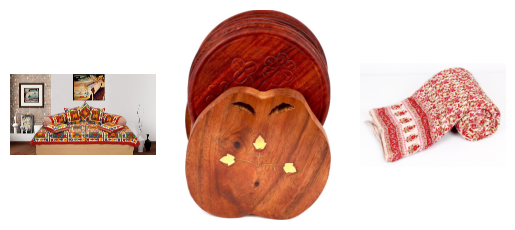

Baby Care 


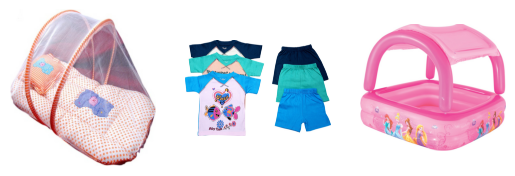

Watches 


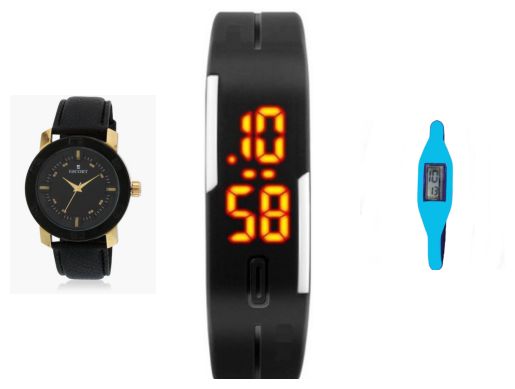

Home Decor & Festive Needs 


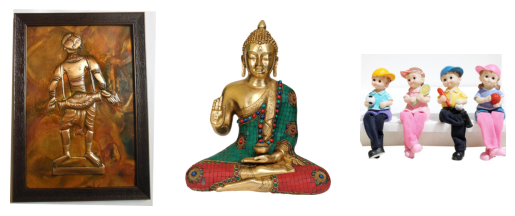

Kitchen & Dining 


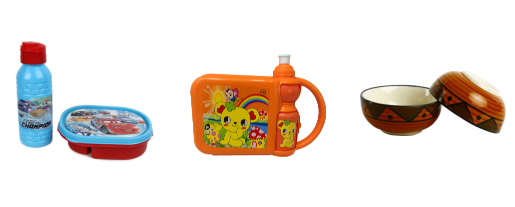

Beauty and Personal Care 


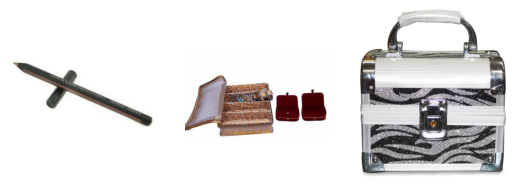

Computers 


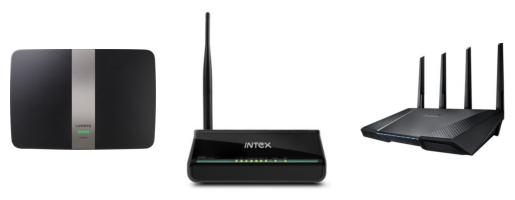

In [7]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.image import imread

le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["catA"])

# Fonction pour obtenir une liste d'images par catégorie
def list_fct(name):
    return data.loc[data["catA"] == name, "image"].tolist()

# Création de variables dynamiques stockant les images par catégorie
category_names = data["catA"].unique()
category_images = {categ: list_fct(categ) for categ in category_names}

# Affichage d'un échantillon d'images par catégorie
for name in category_names:
    print(name)
    for i in range(3):
        plt.subplot(1, 3, i+1)
        filename = IMAGE_DIR + category_images[name][i+10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis("off")
    plt.show()


In [8]:
# Importation des bibliothèques
from keras.applications import EfficientNetB3
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

from PIL import Image, ImageOps
import numpy as np
from tqdm import tqdm  # Pour afficher la barre de progression
import warnings

warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# Initialisation du tableau X (images prétraitées)
X = []

# Parcours de toutes les images
for image_num in tqdm(range(len(list_photos))):
    # Charger l'image
    img = load_img(IMAGE_DIR + data["image"][image_num], target_size=(300, 300))  # EfficientNet attend du 300x300

    # Appliquer l'égalisation de l'histogramme
    img = ImageOps.equalize(img, mask=None)

    # Convertir en tableau NumPy
    img = np.array(img)

    # Reshape pour correspondre aux attentes du modèle
    reshaped_img = img.reshape(300, 300, 3)

    # Prétraitement spécifique à EfficientNet
    imgx = preprocess_input(reshaped_img)

    # Ajouter à la liste des images
    X.append(imgx)

# Convertir X en numpy array
X = np.array(X)

# Charger EfficientNetB3 pré-entraîné sur ImageNet
EfficientNetB3_model = EfficientNetB3(weights="imagenet")

# Modifier le modèle pour extraire les features de la dernière couche avant classification
EfficientNetB3_model = Model(inputs=EfficientNetB3_model.inputs,
                             outputs=EfficientNetB3_model.layers[-2].output)  # Avant la couche softmax

# Générer les features
features = EfficientNetB3_model.predict(X,  batch_size=32)

# Afficher la forme des features extraits
print("Features extraits (shape) :", features.shape)


100%|██████████| 1050/1050 [00:04<00:00, 236.14it/s]
/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 300, 300, 3))
  warnings.warn(msg)


32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step

/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 941ms/step
Features extraits (shape) : (1050, 1536)


In [9]:
# kmeans
ARI_results = np.empty(shape=[0, 3])

ARI, labels = kmeans_fct(features, data["catA"])

ARI_results = np.append(ARI_results, [["EfficientNetB3", "None", ARI]], axis=0)

ARI :  0.4543


In [10]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, data["catA"])

ARI_results = np.append(ARI_results, [["EfficientNetB3", "PCA", ARI]], axis=0)

Components before PCA: 1536
Components after PCA: 723
ARI :  0.4345


/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.5501


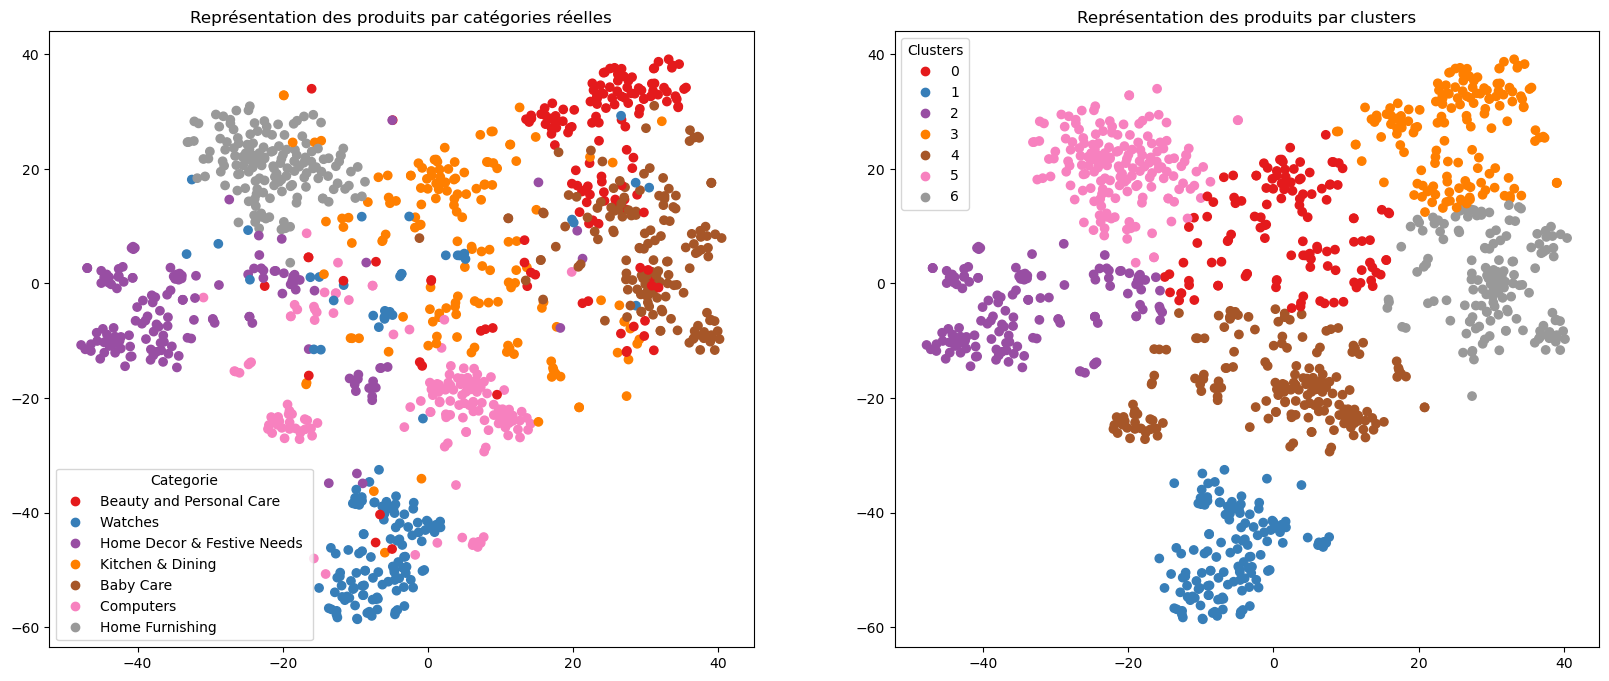

In [11]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data["catA"])
reduc_visu_fct(X_reduc, data["catA"], labels)

ARI_results = np.append(ARI_results, [["EfficientNetB3", "TSNE", ARI]], axis=0)

In [12]:
# Importation des bibliothèques
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.convnext import preprocess_input

from PIL import Image, ImageOps
import numpy as np
from tqdm import tqdm 
import warnings

warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# Initialisation du tableau X (images prétraitées)
X = []

# Parcours de toutes les images
for image_num in tqdm(range(len(list_photos))):
    # Charger l'image
    img = load_img(IMAGE_DIR + data["image"][image_num], target_size=(224, 224))  # ConvNeXt attend du 224x224

    # Appliquer l'égalisation de l'histogramme
    img = ImageOps.equalize(img, mask=None)

    # Convertir en tableau NumPy
    img = np.array(img)

    # Reshape pour correspondre aux attentes du modèle
    reshaped_img = img.reshape(224, 224, 3)

    # Prétraitement spécifique à ConvNeXt
    imgx = preprocess_input(reshaped_img)

    # Ajouter à la liste des images
    X.append(imgx)

# Convertir X en numpy array
X = np.array(X)

# Charger ConvNeXtBase pré-entraîné sur ImageNet
ConvNeXt_model = ConvNeXtBase(weights="imagenet")

# Modifier le modèle pour extraire les features de la dernière couche avant classification
ConvNeXt_model = Model(inputs=ConvNeXt_model.inputs,
                       outputs=ConvNeXt_model.layers[-2].output)  # Juste avant la couche softmax

# Générer les features
features = ConvNeXt_model.predict(X, batch_size=32)

# Afficher la forme des features extraits
print("Features extraits (shape) :", features.shape)


100%|██████████| 1050/1050 [00:04<00:00, 225.74it/s]


355031056/355031056 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_388']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1744178404.896023  339845 service.cc:152] XLA service 0x3aa822780 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744178404.896032  339845 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1744178404.939326  339845 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/33 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_388']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 432s 13s/step
Features extraits (shape) : (1050, 1024)


In [13]:
# kmeans

ARI, labels = kmeans_fct(features, data["catA"])

ARI_results = np.append(ARI_results, [["ConvNeXtBase", "None", ARI]], axis=0)

ARI :  0.5493


In [14]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, data["catA"])

ARI_results = np.append(ARI_results, [["ConvNeXtBase", "PCA", ARI]], axis=0)

Components before PCA: 1024
Components after PCA: 607
ARI :  0.504


/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.5599


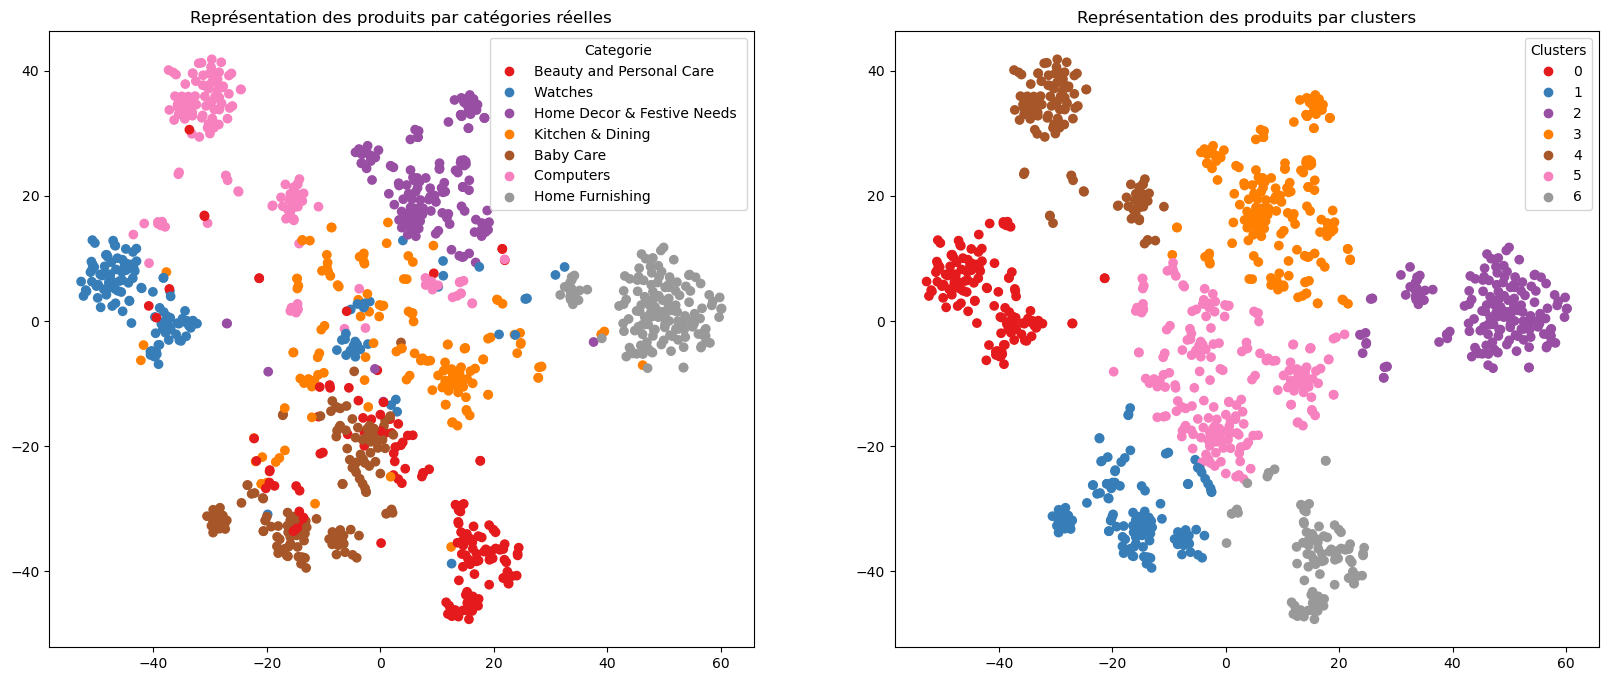

In [15]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data["catA"])
reduc_visu_fct(X_reduc, data["catA"], labels)

ARI_results = np.append(ARI_results, [["ConvNeXtBase", "TSNE", ARI]], axis=0)

In [16]:
df_ari_results = pd.DataFrame(
    ARI_results, columns=["Modèle", "Réduction", "ARI"])
df_ari_results['ARI'] = df_ari_results['ARI'].astype(float)

In [17]:
df_ari_results

,Modèle,Réduction,ARI
0,EfficientNetB3,None,0.4543
1,EfficientNetB3,PCA,0.4345
2,EfficientNetB3,TSNE,0.5501
3,ConvNeXtBase,None,0.5493
4,ConvNeXtBase,PCA,0.5040
5,ConvNeXtBase,TSNE,0.5599


/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


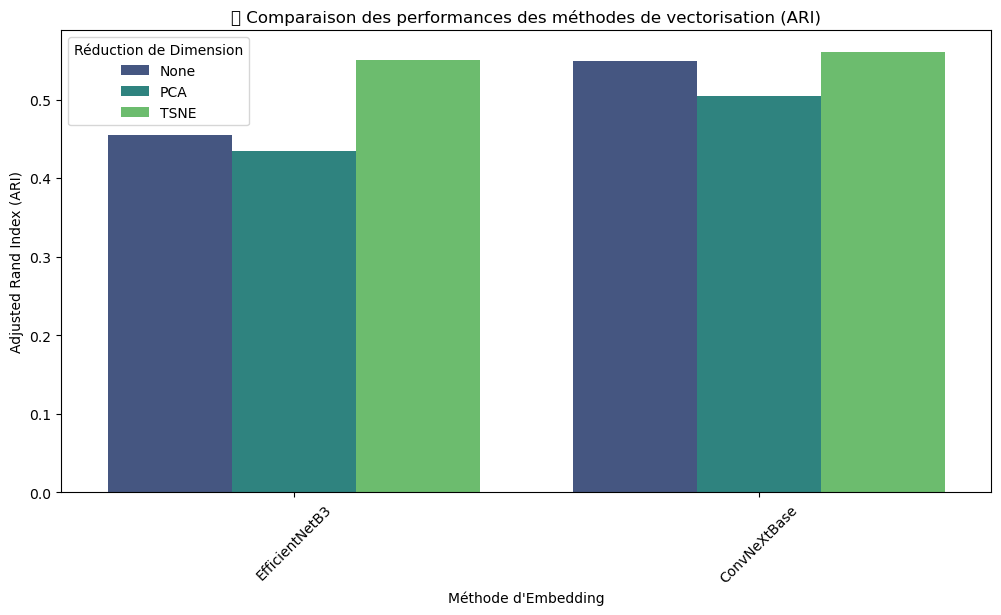

In [18]:
import seaborn as sns

# 📌 Visualisation des scores ARI
plt.figure(figsize=(12, 6))
sns.barplot(data=df_ari_results, x="Modèle", y="ARI", hue="Réduction", palette="viridis")

plt.ylabel("Adjusted Rand Index (ARI)")
plt.xlabel("Méthode d'Embedding")
plt.title("📊 Comparaison des performances des méthodes de vectorisation (ARI)")
plt.xticks(rotation=45)
plt.legend(title="Réduction de Dimension")

plt.show()

In [19]:
# Recréation des features du meilleur modèle
X = []

for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(IMAGE_DIR+data["image"][image_num], target_size=(300, 300))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(300, 300, 3)
    imgx = preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)


features = EfficientNetB3_model.predict(X,batch_size=32)

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['catA'])

100%|██████████| 1050/1050 [00:04<00:00, 218.21it/s]


33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 938ms/step


/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.5501


/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


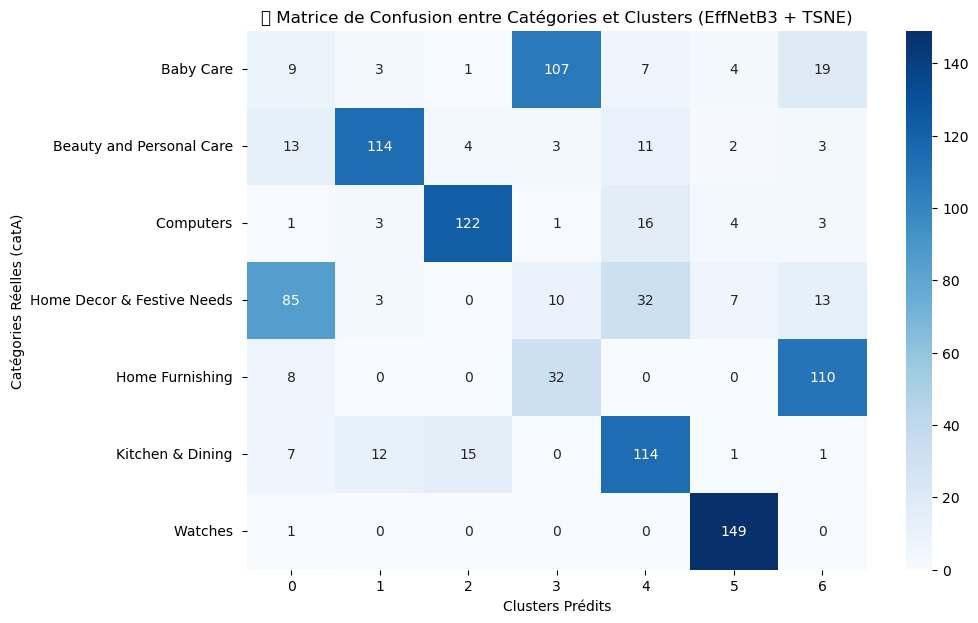

In [ ]:
from sklearn.metrics import confusion_matrix

#  Conversion des labels réels en entiers
label_encoder = LabelEncoder()
true_labels_numeric = label_encoder.fit_transform(data["catA"])  # Convertit les catégories en nombres

# Création de la Matrice de Confusion
conf_matrix = confusion_matrix(true_labels_numeric, labels)

# Affichage de la Matrice de Confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(labels), 
            yticklabels=label_encoder.classes_)  # Affichage des noms de catégories réelles

plt.xlabel("Clusters Prédits")
plt.ylabel("Catégories Réelles (catA)")
plt.title("📊 Matrice de Confusion entre Catégories et Clusters (EffNetB3 + TSNE)")
plt.show()

In [22]:
# Initialisation du tableau X (images prétraitées)
X = []

# Parcours de toutes les images
for image_num in tqdm(range(len(list_photos))):
    # Charger l'image
    img = load_img(IMAGE_DIR + data["image"][image_num], target_size=(224, 224))  # ConvNeXt attend du 224x224

    # Appliquer l'égalisation de l'histogramme
    img = ImageOps.equalize(img, mask=None)

    # Convertir en tableau NumPy
    img = np.array(img)

    # Reshape pour correspondre aux attentes du modèle
    reshaped_img = img.reshape(224, 224, 3)

    # Prétraitement spécifique à ConvNeXt
    imgx = preprocess_input(reshaped_img)

    # Ajouter à la liste des images
    X.append(imgx)

# Convertir X en numpy array
X = np.array(X)

# Charger ConvNeXtBase pré-entraîné sur ImageNet
ConvNeXt_model = ConvNeXtBase(weights="imagenet")

# Modifier le modèle pour extraire les features de la dernière couche avant classification
ConvNeXt_model = Model(inputs=ConvNeXt_model.inputs,
                       outputs=ConvNeXt_model.layers[-2].output)  # Juste avant la couche softmax

# Générer les features
features = ConvNeXt_model.predict(X, batch_size=32)

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['catA'])

100%|██████████| 1050/1050 [00:04<00:00, 226.07it/s]
/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_697']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


32/33 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_697']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 430s 13s/step


/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.5599


/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


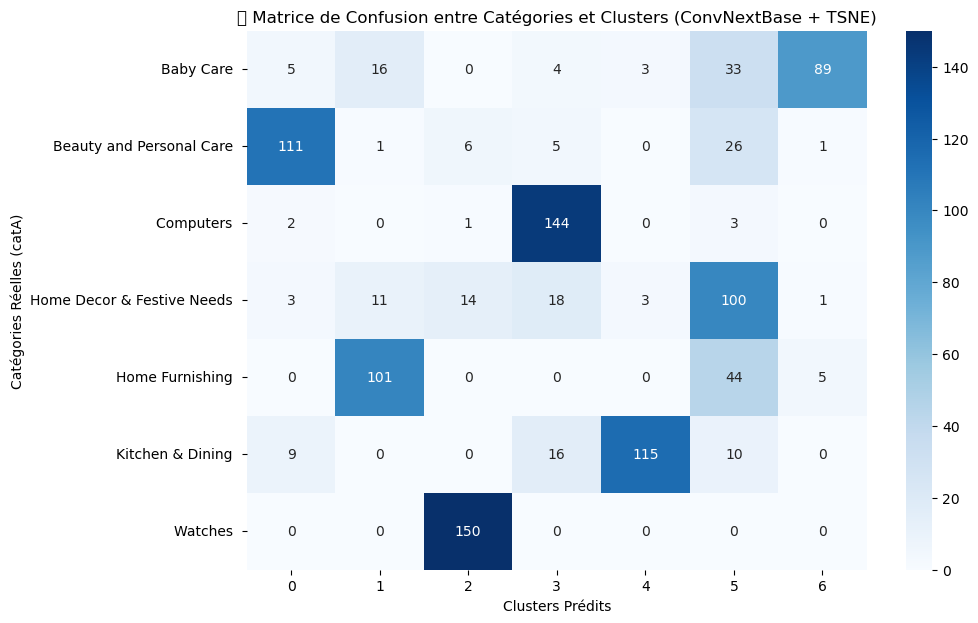

In [23]:
from sklearn.metrics import confusion_matrix

#  Conversion des labels réels en entiers
label_encoder = LabelEncoder()
true_labels_numeric = label_encoder.fit_transform(data["catA"])  # Convertit les catégories en nombres

# Création de la Matrice de Confusion
conf_matrix = confusion_matrix(true_labels_numeric, labels)

# Affichage de la Matrice de Confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(labels), 
            yticklabels=label_encoder.classes_)  # Affichage des noms de catégories réelles

plt.xlabel("Clusters Prédits")
plt.ylabel("Catégories Réelles (catA)")
plt.title("📊 Matrice de Confusion entre Catégories et Clusters (ConvNextBase + TSNE)")
plt.show()

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.applications.convnext import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

# Charger le modèle pré-entraîné
model = ConvNeXtBase(weights="imagenet", include_top=True)

# Charger et prétraiter une image
img_path = "./Images/c705a5735a94aeee547d1798e3e46ec4.jpg" 
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))

In [46]:
# Sélection de la dernière couche de convolution
last_conv_layer_name = "convnext_base_stage_3_block_2_depthwise_conv"  # à adapter si custom model

# Créer un modèle intermédiaire
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

# Calcul du gradient
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_preprocessed)
    class_idx = tf.argmax(predictions[0])
    loss = predictions[:, class_idx]

# Gradient par rapport aux activations
grads = tape.gradient(loss, conv_outputs)[0]

# Moyenne des gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Pondérer les cartes d'activation
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Normaliser la carte
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

/Users/gillestellier/miniforge3/envs/jupyenv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3787']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


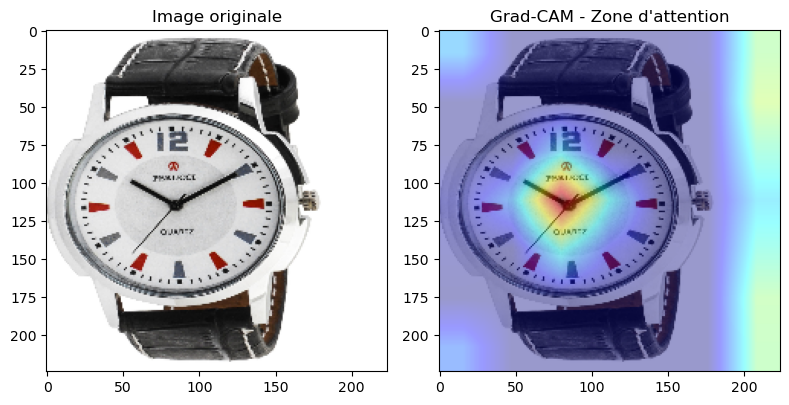

In [47]:
# Charger image originale en BGR
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

# Convertir heatmap en couleur
heatmap = cv2.resize(heatmap.numpy(), (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superposition
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

# Affichage
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Image originale")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM - Zone d'attention")
plt.tight_layout()
plt.show()